In [1]:
from neuralprophet import NeuralProphet
from fbprophet import Prophet
import pandas as pd
from math import sin, pi, isnan
from random import gauss, random
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, SmoothL1Loss=0.00774, MAE=1.12e+3, RegLoss=0]


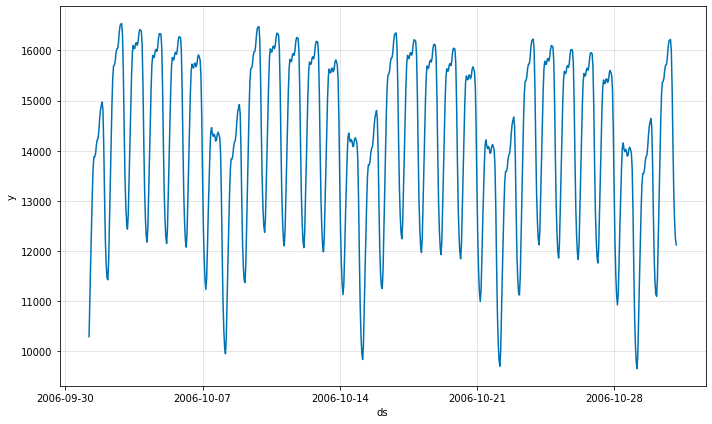

In [2]:
# download data
#df = pd.read_csv('https://github.com/khsieh18/Time-Series/raw/master/AEP_hourly.csv')
df = pd.read_csv('/Users/mtrencseni/AEP_hourly.csv')
# rename columns, NeuralProphet expects ds and y
df.columns = ['ds', 'y']
df['ds'] = df['ds'].astype('datetime64[ns]')
# keep training data
training_days = 2*365
forecast_days = 30
df = df.sort_values(['ds']).head(training_days * 24)
df.index = np.arange(0, len(df))
# train model
model = NeuralProphet(yearly_seasonality=True)
model.fit(df, freq="H")
# forecast
df_predict = model.make_future_dataframe(df, periods=forecast_days * 24)
df_predict = model.predict(df_predict)
fig = model.plot(df_predict)

In [3]:
def compute_mape(df, df_predict, forecast_days):
    df_cross = df.tail(forecast_days*24).merge(right=df_predict, on='ds', suffixes=['', '_predict'])
    df_cross = df_cross[['ds', 'gt', 'yhat']]
    mape = mean([2 * abs((row['gt'] - row['yhat']) / (row['gt'] + row['yhat'])) for _, row in df_cross.iterrows()])
    return mape

def prepare_dfs(csv_path, training_days, forecast_days, drop_ratio=0.0):
    df = pd.read_csv(csv_path)
    # rename columns, Prophet expects ds and y
    df.columns = ['ds', 'y']
    df['ds'] = df['ds'].astype('datetime64[ns]')
    df = df.sort_values(['ds']).head((training_days + forecast_days) * 24)
    df.index = np.arange(0, len(df))
    # save ground truth
    df['gt'] = df['y']
    # wipe target variable y for to-be-forecasted section
    for i, row in df.iterrows():
        if i >= training_days * 24:
            df.at[i, 'y'] = None
    drop_inds = [i for i in range(len(df)) if random() < drop_ratio and i < len(df) - forecast_days * 24]
    df = df.drop(df.index[drop_inds])
    df_train = df.dropna()[['ds', 'y']]
    return df, df_train

def fbprophet_test(model, csv_path, training_days, forecast_days, drop_ratio=0.0):
    df, df_train = prepare_dfs(csv_path, training_days, forecast_days, drop_ratio)
    model.fit(df_train)
    df_predict = df[['ds']]
    df_predict = model.predict(df_predict)[['ds', 'yhat']]
    return compute_mape(df, df_predict, forecast_days)

def neuralprophet_test(model, csv_path, training_days, forecast_days, drop_ratio=0.0):
    df, df_train = prepare_dfs(csv_path, training_days, forecast_days, drop_ratio)
    model.fit(df_train, freq="H")
    df_predict = model.make_future_dataframe(df_train, periods=forecast_days * 24)
    df_predict = model.predict(df_predict)[['ds', 'yhat1']].rename(columns={'yhat1': 'yhat'})
    return compute_mape(df, df_predict, forecast_days)

In [4]:
csv_path='/Users/mtrencseni/AEP_hourly.csv'
training_years = [1, 2, 3, 4, 5]
forecast_months = [1, 2, 3, 6, 9, 12]
models = [
    (lambda: Prophet(yearly_seasonality=True), fbprophet_test),
    (lambda: NeuralProphet(yearly_seasonality=True), neuralprophet_test),
]
results = []
for ty in training_years:
    for fm in forecast_months:
        for funcs in models:
            training_days = int(ty * 365)
            forecast_days = int(fm * 30)
            start = time.time()
            model = funcs[0]()
            test_func = funcs[1]
            mape = test_func(model, csv_path, training_days, forecast_days)
            elapsed = time.time() - start
            print('%s, training years=%d, forecast months=%d, MAPE = %.2f, elapsed secs = %.2f' % (model.__class__.__name__, ty, fm, mape, elapsed))
            results.append((model.__class__.__name__, ty, fm, mape, elapsed))
print('\nDone!')

Prophet, training years=1, forecast months=1, MAPE = 0.04, elapsed secs = 6.44


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s, SmoothL1Loss=0.00814, MAE=1.14e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=1, MAPE = 0.08, elapsed secs = 3.82
Prophet, training years=1, forecast months=2, MAPE = 0.06, elapsed secs = 6.10


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s, SmoothL1Loss=0.00831, MAE=1.15e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=2, MAPE = 0.07, elapsed secs = 3.92
Prophet, training years=1, forecast months=3, MAPE = 0.07, elapsed secs = 6.40


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.44it/s, SmoothL1Loss=0.0082, MAE=1.15e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=3, MAPE = 0.08, elapsed secs = 4.06
Prophet, training years=1, forecast months=6, MAPE = 0.08, elapsed secs = 7.46


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.46it/s, SmoothL1Loss=0.00834, MAE=1.16e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=6, MAPE = 0.08, elapsed secs = 4.38
Prophet, training years=1, forecast months=9, MAPE = 0.07, elapsed secs = 8.64


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s, SmoothL1Loss=0.00834, MAE=1.16e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=9, MAPE = 0.08, elapsed secs = 4.72
Prophet, training years=1, forecast months=12, MAPE = 0.07, elapsed secs = 9.80


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 32
INFO:nprophet.config:Auto-set batch_size to 32
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.39it/s, SmoothL1Loss=0.00823, MAE=1.15e+3, RegLoss=0]


NeuralProphet, training years=1, forecast months=12, MAPE = 0.07, elapsed secs = 5.08
Prophet, training years=2, forecast months=1, MAPE = 0.12, elapsed secs = 36.64


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s, SmoothL1Loss=0.00765, MAE=1.11e+3, RegLoss=0]


NeuralProphet, training years=2, forecast months=1, MAPE = 0.08, elapsed secs = 4.59
Prophet, training years=2, forecast months=2, MAPE = 0.12, elapsed secs = 37.00


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s, SmoothL1Loss=0.00766, MAE=1.11e+3, RegLoss=0]


NeuralProphet, training years=2, forecast months=2, MAPE = 0.08, elapsed secs = 4.67
Prophet, training years=2, forecast months=3, MAPE = 0.11, elapsed secs = 36.72


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.36it/s, SmoothL1Loss=0.0077, MAE=1.12e+3, RegLoss=0] 


NeuralProphet, training years=2, forecast months=3, MAPE = 0.08, elapsed secs = 4.78
Prophet, training years=2, forecast months=6, MAPE = 0.18, elapsed secs = 37.76


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.34it/s, SmoothL1Loss=0.00771, MAE=1.12e+3, RegLoss=0]


NeuralProphet, training years=2, forecast months=6, MAPE = 0.10, elapsed secs = 5.17
Prophet, training years=2, forecast months=9, MAPE = 0.24, elapsed secs = 38.77


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:02<00:00,  2.35it/s, SmoothL1Loss=0.00766, MAE=1.11e+3, RegLoss=0]


NeuralProphet, training years=2, forecast months=9, MAPE = 0.10, elapsed secs = 5.54
Prophet, training years=2, forecast months=12, MAPE = 0.25, elapsed secs = 39.89


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 7
INFO:nprophet.config:Auto-set epochs to 7


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[7/7]: 100%|██████████| 7/7 [00:03<00:00,  2.31it/s, SmoothL1Loss=0.00771, MAE=1.12e+3, RegLoss=0]


NeuralProphet, training years=2, forecast months=12, MAPE = 0.09, elapsed secs = 5.85
Prophet, training years=3, forecast months=1, MAPE = 0.10, elapsed secs = 45.49


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.87E-01
INFO:nprophet:learning rate range test found optimal lr: 1.87E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s, SmoothL1Loss=0.00822, MAE=1.2e+3, RegLoss=0] 


NeuralProphet, training years=3, forecast months=1, MAPE = 0.07, elapsed secs = 5.22
Prophet, training years=3, forecast months=2, MAPE = 0.11, elapsed secs = 46.51


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s, SmoothL1Loss=0.00834, MAE=1.21e+3, RegLoss=0]


NeuralProphet, training years=3, forecast months=2, MAPE = 0.08, elapsed secs = 5.35
Prophet, training years=3, forecast months=3, MAPE = 0.13, elapsed secs = 46.27


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s, SmoothL1Loss=0.00852, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=3, forecast months=3, MAPE = 0.08, elapsed secs = 5.54
Prophet, training years=3, forecast months=6, MAPE = 0.16, elapsed secs = 47.81


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s, SmoothL1Loss=0.00833, MAE=1.2e+3, RegLoss=0]


NeuralProphet, training years=3, forecast months=6, MAPE = 0.08, elapsed secs = 5.81
Prophet, training years=3, forecast months=9, MAPE = 0.19, elapsed secs = 48.26


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s, SmoothL1Loss=0.00821, MAE=1.2e+3, RegLoss=0]


NeuralProphet, training years=3, forecast months=9, MAPE = 0.09, elapsed secs = 6.21
Prophet, training years=3, forecast months=12, MAPE = 0.21, elapsed secs = 49.39


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s, SmoothL1Loss=0.0083, MAE=1.2e+3, RegLoss=0] 


NeuralProphet, training years=3, forecast months=12, MAPE = 0.10, elapsed secs = 6.60
Prophet, training years=4, forecast months=1, MAPE = 0.05, elapsed secs = 30.28


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 6.58E-01
INFO:nprophet:learning rate range test found optimal lr: 6.58E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.0084, MAE=1.23e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=1, MAPE = 0.06, elapsed secs = 6.81
Prophet, training years=4, forecast months=2, MAPE = 0.07, elapsed secs = 30.63


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s, SmoothL1Loss=0.00829, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=2, MAPE = 0.07, elapsed secs = 7.01
Prophet, training years=4, forecast months=3, MAPE = 0.07, elapsed secs = 30.87


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.00805, MAE=1.2e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=3, MAPE = 0.07, elapsed secs = 7.05
Prophet, training years=4, forecast months=6, MAPE = 0.08, elapsed secs = 31.97


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.00833, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=6, MAPE = 0.09, elapsed secs = 7.36
Prophet, training years=4, forecast months=9, MAPE = 0.08, elapsed secs = 33.12


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s, SmoothL1Loss=0.00813, MAE=1.21e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=9, MAPE = 0.09, elapsed secs = 7.86
Prophet, training years=4, forecast months=12, MAPE = 0.09, elapsed secs = 34.24


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 5.34E-01
INFO:nprophet:learning rate range test found optimal lr: 5.34E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, SmoothL1Loss=0.00844, MAE=1.23e+3, RegLoss=0]


NeuralProphet, training years=4, forecast months=12, MAPE = 0.09, elapsed secs = 8.13
Prophet, training years=5, forecast months=1, MAPE = 0.06, elapsed secs = 367.12


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it, SmoothL1Loss=0.00828, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=1, MAPE = 0.05, elapsed secs = 8.34
Prophet, training years=5, forecast months=2, MAPE = 0.06, elapsed secs = 91.01


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it, SmoothL1Loss=0.00829, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=2, MAPE = 0.06, elapsed secs = 8.52
Prophet, training years=5, forecast months=3, MAPE = 0.06, elapsed secs = 97.07


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it, SmoothL1Loss=0.00841, MAE=1.23e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=3, MAPE = 0.07, elapsed secs = 8.63
Prophet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 93.07


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it, SmoothL1Loss=0.0083, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.10, elapsed secs = 8.90
Prophet, training years=5, forecast months=9, MAPE = 0.12, elapsed secs = 93.58


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it, SmoothL1Loss=0.00825, MAE=1.21e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=9, MAPE = 0.10, elapsed secs = 9.32
Prophet, training years=5, forecast months=12, MAPE = 0.14, elapsed secs = 100.08


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.11s/it, SmoothL1Loss=0.0086, MAE=1.24e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=12, MAPE = 0.11, elapsed secs = 10.26

Done!


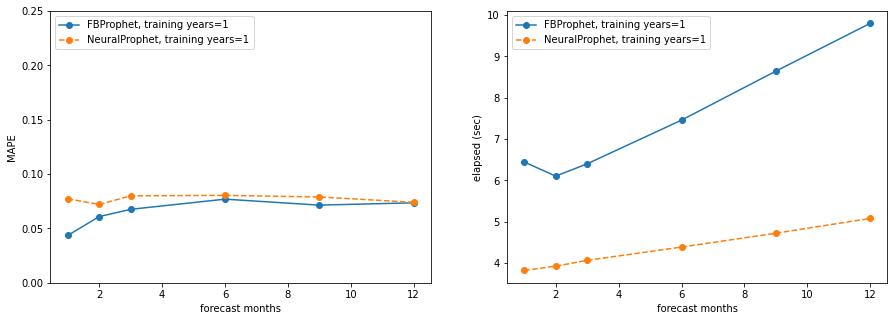

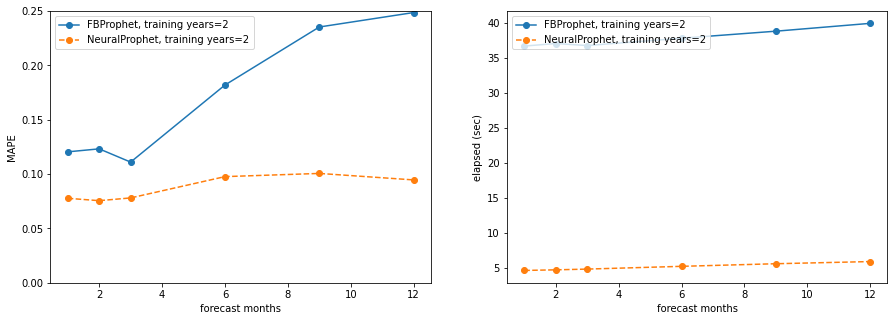

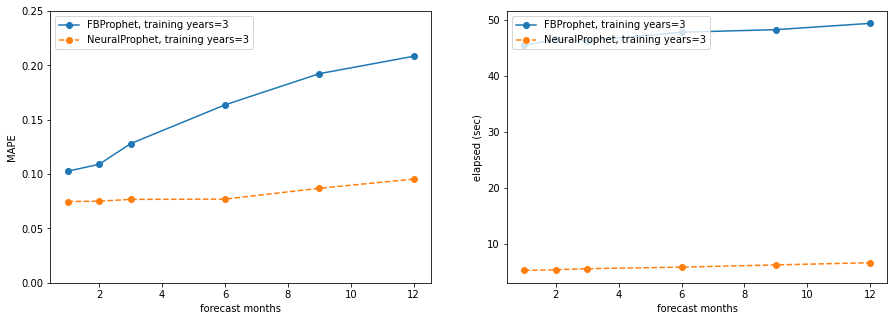

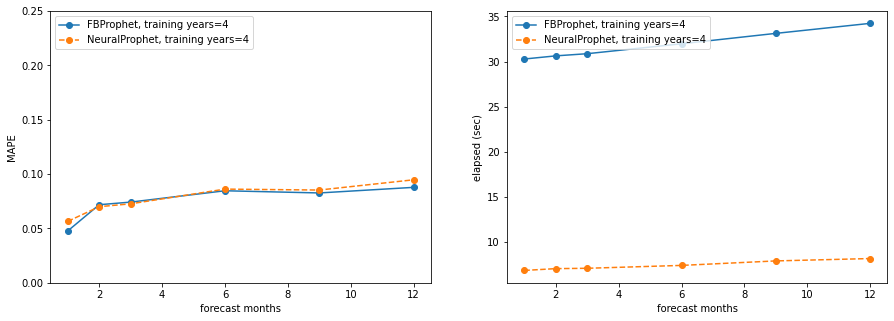

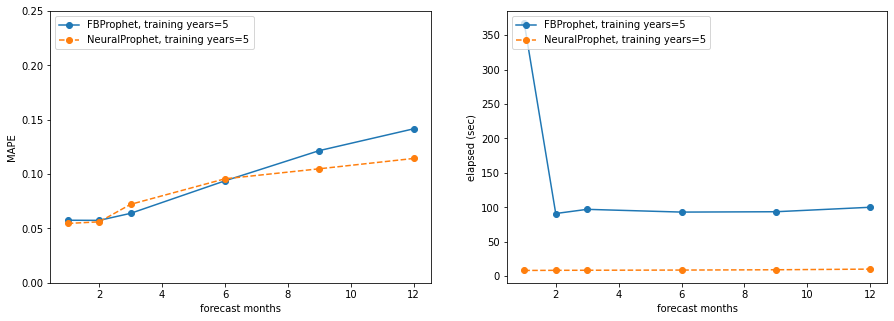

In [7]:
for ty in training_years:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_xlabel('forecast months')
    ax1.set_ylabel('MAPE')
    ax1.set_ylim(0, 0.25)
    legends = []
    ax1.plot(
        [r[2] for r in results if r[0] == 'Prophet' and r[1] == ty],
        [r[3] for r in results if r[0] == 'Prophet' and r[1] == ty],
        marker='o', linestyle='-')
    legends.append('FBProphet, training years=%d' % ty)
    ax1.plot(
        [r[2] for r in results if r[0] == 'NeuralProphet' and r[1] == ty],
        [r[3] for r in results if r[0] == 'NeuralProphet' and r[1] == ty],
        marker='o', linestyle='--')
    legends.append('NeuralProphet, training years=%d' % ty)
    ax1.legend(legends, loc='upper left')
    ax2.set_xlabel('forecast months')
    ax2.set_ylabel('elapsed (sec)')
    legends = []
    ax2.plot(
        [r[2] for r in results if r[0] == 'Prophet' and r[1] == ty],
        [r[4] for r in results if r[0] == 'Prophet' and r[1] == ty],
        marker='o', linestyle='-')
    legends.append('FBProphet, training years=%d' % ty)
    ax2.plot(
        [r[2] for r in results if r[0] == 'NeuralProphet' and r[1] == ty],
        [r[4] for r in results if r[0] == 'NeuralProphet' and r[1] == ty],
        marker='o', linestyle='--')
    legends.append('NeuralProphet, training years=%d' % ty)
    ax2.legend(legends, loc='upper left')
    fig.show()

In [8]:
csv_path='/Users/mtrencseni/AEP_hourly.csv'
ty = 5
fm = 6
drop_ratios = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
models = [
    (lambda: Prophet(yearly_seasonality=True), fbprophet_test),
    (lambda: NeuralProphet(yearly_seasonality=True), neuralprophet_test),
]
results2 = []
for drop_ratio in drop_ratios:
    for funcs in models:
        training_days = int(ty * 365)
        forecast_days = int(fm * 30)
        start = time.time()
        model = funcs[0]()
        test_func = funcs[1]
        mape = test_func(model, csv_path, training_days, forecast_days, drop_ratio)
        elapsed = time.time() - start
        print('%s, training years=%d, forecast months=%d, MAPE = %.2f, elapsed secs = %.2f, drop_ratio=%.1f' % (model.__class__.__name__, ty, fm, mape, elapsed, drop_ratio))
        results2.append((model.__class__.__name__, ty, fm, mape, elapsed, drop_ratio))
print('\nDone!')

Prophet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 102.96, drop_ratio=0.0


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it, SmoothL1Loss=0.00833, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 9.76, drop_ratio=0.0
Prophet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 88.68, drop_ratio=0.1


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it, SmoothL1Loss=0.00837, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 9.24, drop_ratio=0.1
Prophet, training years=5, forecast months=6, MAPE = 0.10, elapsed secs = 59.74, drop_ratio=0.2


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 8.11E-01
INFO:nprophet:learning rate range test found optimal lr: 8.11E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s, SmoothL1Loss=0.00853, MAE=1.23e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 7.94, drop_ratio=0.2
Prophet, training years=5, forecast months=6, MAPE = 0.10, elapsed secs = 53.76, drop_ratio=0.3


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 3.51E-01
INFO:nprophet:learning rate range test found optimal lr: 3.51E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s, SmoothL1Loss=0.00866, MAE=1.23e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 7.45, drop_ratio=0.3
Prophet, training years=5, forecast months=6, MAPE = 0.10, elapsed secs = 45.95, drop_ratio=0.4


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s, SmoothL1Loss=0.00866, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 6.88, drop_ratio=0.4
Prophet, training years=5, forecast months=6, MAPE = 0.10, elapsed secs = 34.85, drop_ratio=0.5


INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 128
INFO:nprophet.config:Auto-set batch_size to 128
INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 5
INFO:nprophet.config:Auto-set epochs to 5


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
INFO:nprophet:learning rate range test found optimal lr: 2.85E-01
Epoch[5/5]: 100%|██████████| 5/5 [00:02<00:00,  1.87it/s, SmoothL1Loss=0.0084, MAE=1.22e+3, RegLoss=0]


NeuralProphet, training years=5, forecast months=6, MAPE = 0.09, elapsed secs = 6.32, drop_ratio=0.5

Done!


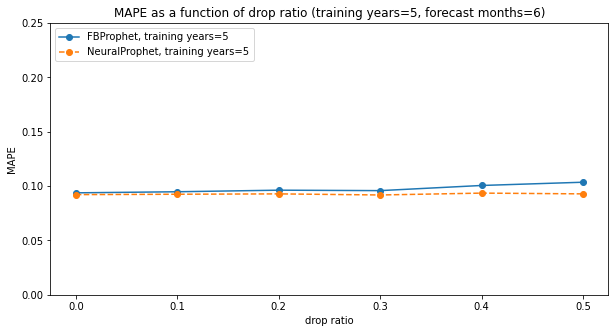

In [9]:
plt.figure(figsize=(10, 5))
plt.title('MAPE as a function of drop ratio (training years=5, forecast months=6)')
plt.xlabel('drop ratio')
plt.ylabel('MAPE')
plt.ylim(0, 0.25)
legends = []
plt.plot(
    [r[5] for r in results2 if r[0] == 'Prophet' and r[1] == ty],
    [r[3] for r in results2 if r[0] == 'Prophet' and r[1] == ty],
    marker='o', linestyle='-')
legends.append('FBProphet, training years=%d' % ty)
plt.plot(
    [r[5] for r in results2 if r[0] == 'NeuralProphet' and r[1] == ty],
    [r[3] for r in results2 if r[0] == 'NeuralProphet' and r[1] == ty],
    marker='o', linestyle='--')
legends.append('NeuralProphet, training years=%d' % ty)
plt.legend(legends, loc='upper left')
plt.show()